In [1]:
import sys
import os
import pickle
from scipy import sparse
import scanpy as sc
import anndata as ad
from anndata import AnnData
import scvi
import pandas as pd
import numpy as np
from scipy import  sparse

import torch
import torch.nn.functional as F
import torch.nn as nn

from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.genotypevae.genotypeVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import SCVIZ_CheckNet2Net


%load_ext autoreload
%autoreload 2
%matplotlib inline

#  Example data and preprocssing

1. Exmaple datasets are the subset of dataset from Norman dataset (GSE133344)

2. The preprocessing mainly follows the scanpy's pipeline. including:  
```
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=5, min_disp=0.5)
```

3. All highly variable genes are seleceted for the model training and down stream analyis

4. Differentially expressed genes are calculated using:

```
# your treatment columns in the adata.obs
groups = "treatment"
# your reference level treatment
control = "ctrl"
sc.tl.rank_genes_groups(adata, n_genes = 50, method = "t-test", corr_method = "benjamini-hochberg",groupby = groups,
 reference = control)
```

In [2]:
adata = ad.read_h5ad("./../example_data/Norman_example.h5ad")

In [62]:
adata

AnnData object with n_obs × n_vars = 44497 × 2279
    obs: 'perturb_string', 'n_counts', 'n_counts_total', 'if_remove', 'num_gene_perturbed', '1st_ge_selected_holdout', '2nd_ge_selected_holdout', '3rd_ge_selected_holdout', 'GI_TYPE', '4th_ge_selected_holdout', '5th_ge_selected_holdout', 'split_example'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', 'hvg', 'lib_single_gene_onehot', 'log1p', 'ordered_all_onehot', 'ordered_all_trt', 'rank_genes_groups', 'rank_genes_groups_t_test'
    layers: 'counts'

# Convert genetic perturbation to one-hot vector
1. To use the pretrained genotypeVAE, you need to convert your genetic perturbations into one-hot vectors of GO annotations. We provide our annotation files to help you convert your new treatment. 
2. Norman dataset has its all treatment in  ```adata.uns["ordered_all_trt"]``` and their corresponding one-hot matrix are stored in ```adata.uns["ordered_all_onehot"]```

In [38]:
path_data = "./../pretrained_model/genotypeVAE/sparse_gene_anno_matrix.npz"
data_npz = sparse.load_npz(path_data).toarray()
path_geneanno = "./../pretrained_model/genotypeVAE/"
gene_data = np.load(os.path.join(path_geneanno, 'gene.npy'))
indices_with_anno = []
indices_lib = []
perturb_uni = np.array(["AHR", "ARID1A"])
for i in range(perturb_uni.shape[0]):
    gene = perturb_uni[i]
    indice = np.where(gene_data == gene)[0]
    
    if len(indice) != 0:
        indices_with_anno.append(i)
        indices_lib.append(indice[0])
onehot_data = data_npz[indices_lib]
print(onehot_data.shape)


(2, 15988)


**If you perturb multiple genes simutaneously, you can take the union of the one-hot vectors to represent it. For example, to represent a CRISPRa assay targeting AHR and ARID1A:**
```
two_gene_perturbation = np.logical_or(onehot_data[0], onehot_data[1]).astype(int)
```

# Create train-test splits
Add new splits to the anndata. The function will include the control cells in the training split. You can pass a list of controls if you have multiple treatments that need to be arbitrarily included in the training split.

In [47]:
create_train_test_splits_by_key(adata,train_ratio = 0.8, add_key = "split_example", split_key = "perturb_string", 
                                control = ["ctrl"]
                                , random_seed=42)

In [ ]:
adata.write_h5ad("./../example_data/Norman_example.h5ad")

In [3]:
adata_train = adata[adata.obs.split_example == "train",:].copy()
adata_test = adata[adata.obs.split_example == "test",:].copy()

# Train cellular Representation Network

1. Regular VAE for the normalzied expression data and scVI for the raw count expression data.Norman dataset has raw count data, so we used scVI for cellular representation.
2. When training the scVI model, 700 epoches are recommended. The KL warmup requires for 400 epochs. Here we used only 500 epochs to avoid overfitting on the toy dataset

In [54]:

# provide an unexisting directory for saving

scvi_model_save_path = "./Norman_example/cellvae/"
scvi.data.setup_anndata(adata_train , layer = "counts")
scvi_model = scvi.model.SCVI(adata_train, n_latent = 10) 
scvi_model.train(n_epochs = 500,frequency = 20)
scvi_model.save(scvi_model_save_path )

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 35882 cells, 2279 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Training for 500 epochs                                                                                   
INFO     KL warmup for 400 epochs                                       

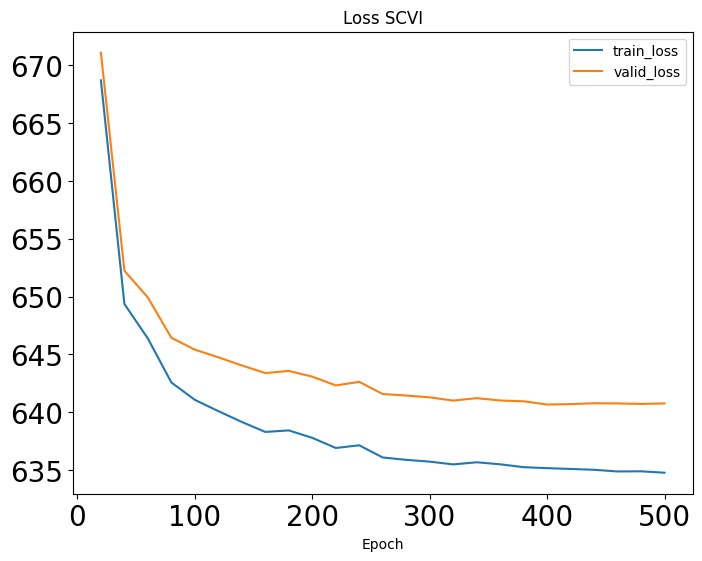

In [55]:
%matplotlib inline
train_loss = np.array(scvi_model.history["elbo_train_set"])
valid_loss = np.array(scvi_model.history["elbo_test_set"])
trainvalid_loss = np.concatenate([train_loss.reshape([train_loss.shape[0], 1]), 
									  valid_loss.reshape([valid_loss.shape[0], 1])], axis = 1)
trainvalid_loss_pd = pd.DataFrame(trainvalid_loss)
trainvalid_loss_pd.columns = ['train_loss', 'valid_loss']
trainvalid_loss_pd['Epoch'] = np.arange(train_loss.shape[0]) * 20
newfig = trainvalid_loss_pd.iloc[1:,].set_index('Epoch').plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss SCVI")
plt.show()

In [4]:
# load_scvi_model
scvi_model_save_path = "./Norman_example/cellvae/"
scvi.data.setup_anndata(adata_train, layer = "counts")
scvi_model = scvi.model.SCVI.load(scvi_model_save_path, adata_train, use_cuda = False)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 35882 cells, 2279 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                         

# Train cinn model 
1. load the genotypeVAE for perturbation representation
2. create the input embeddings and build the cinn 
3. train the cinn, we recommend 50 - 100 epochs for the real dataset. For this toy dataset, we just train the model for 45 epochs.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
path_genovae_model = "./../pretrained_model/genotypeVAE/model_params.pt"
model_genovae = GenotypeVAE().to(device)
model_genovae.load_state_dict(torch.load(path_genovae_model, map_location = device))
model_genovae.eval()

GenotypeVAE(
  (linear_1): Linear(in_features=15988, out_features=512, bias=True)
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (linear_3_mu): Linear(in_features=256, out_features=10, bias=True)
  (linear_3_std): Linear(in_features=256, out_features=10, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_4): Linear(in_features=10, out_features=256, bias=True)
  (linear_5): Linear(in_features=256, out_features=512, bias=True)
  (linear_6): Linear(in_features=512, out_features=15988, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
  (leaky): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
  (dropout1): Dropout(p=0.2, inplace=F

In [7]:
cond_stage_data, embeddings, perturbToEmbed= prepare_embeddings_cinn(adata_train,
                                                                     perturbation_key = "perturb_string", 
                                                                     trt_key = "ordered_all_trt", 
                                                                     embed_key = "ordered_all_onehot")

**build cinn model with customized parameters**
1. conditional_dim: dimension of perturbation latent embeddings
2. embedding_dim: dimension of latent cell embeddings
3. conditioning_depth: number of the layers for conditioanl information input(perturbation latent embeddings)
4. n_flows: number of the flow blocks
5. hidden_dim: dimension of the hidden layers
6. hidden_depth: number of the hidden layers in the flow blocks

In [75]:
path_cinn_model_save = "./Norman_example/cinn/"
torch.manual_seed(42)
flow_model = ConditionalFlatCouplingFlow(conditioning_dim=10,
                                         embedding_dim=10,
                                         conditioning_depth=2,
                                         n_flows=20,
                                         in_channels=10,
                                         hidden_dim=1024,
                                         hidden_depth=2,
                                         activation="none",
                                        conditioner_use_bn=True)

model_c = Net2NetFlow_scVIGenoFlow( configured_flow=flow_model,
                                    cond_stage_data=cond_stage_data,
                                    model_con=model_genovae,
                                    scvi_model = scvi_model,
                                    perturbToOnehotLib = perturbToEmbed,
                                    oneHotData = embeddings)
    
    
# training
model_c.to(device = device)
model_c.train(n_epochs = 45, batch_size = 128, lr = 4.5e-6)
# save the model 
model_c.save(path_cinn_model_save)

Note: Conditioning network uses batch-normalization. Make sure to train with a sufficiently large batch size
[Epoch 1/45] [Batch 57/57] [loss: 4.351103/4.070586]
[Epoch 2/45] [Batch 57/57] [loss: 3.949906/3.862249]
[Epoch 3/45] [Batch 57/57] [loss: 3.734276/3.724241]
[Epoch 4/45] [Batch 57/57] [loss: 3.621964/3.599952]
[Epoch 5/45] [Batch 57/57] [loss: 3.518769/3.544970]
[Epoch 6/45] [Batch 57/57] [loss: 3.443359/3.473071]
[Epoch 7/45] [Batch 57/57] [loss: 3.364973/3.414336]
[Epoch 8/45] [Batch 57/57] [loss: 3.297966/3.351384]
[Epoch 9/45] [Batch 57/57] [loss: 3.235463/3.350574]
[Epoch 10/45] [Batch 57/57] [loss: 3.194128/3.280871]
[Epoch 11/45] [Batch 57/57] [loss: 3.125720/3.261060]
[Epoch 12/45] [Batch 57/57] [loss: 3.106149/3.266817]
[Epoch 13/45] [Batch 57/57] [loss: 3.052140/3.214193]
[Epoch 14/45] [Batch 57/57] [loss: 3.026936/3.222242]
[Epoch 15/45] [Batch 57/57] [loss: 2.994432/3.175390]
[Epoch 16/45] [Batch 57/57] [loss: 2.963135/3.172618]
[Epoch 17/45] [Batch 57/57] [loss: 2

Text(0.5, 1.0, 'Minutes: 27.9')

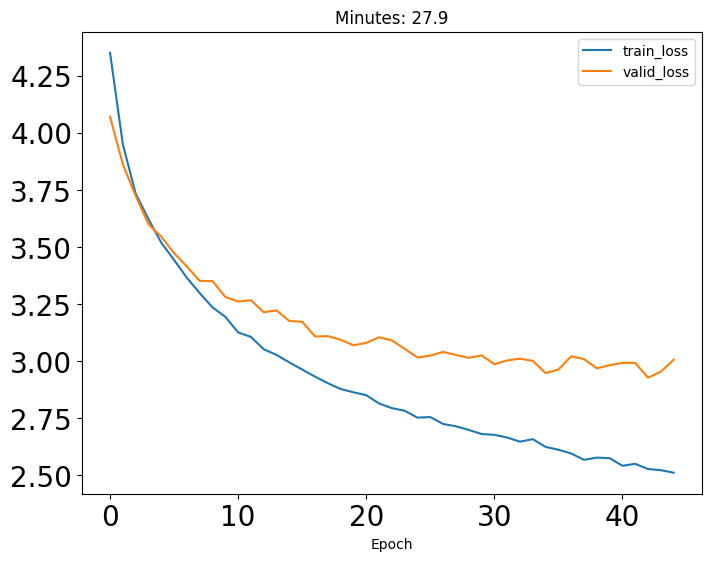

In [76]:

%matplotlib inline
train_loss = np.load(path_cinn_model_save + 'train_loss.npy')
valid_loss = np.load(path_cinn_model_save +'test_loss.npy')
trainvalid_loss = np.concatenate([train_loss.reshape([train_loss.shape[0], 1]), 
									  valid_loss.reshape([valid_loss.shape[0], 1])], axis = 1)
trainvalid_loss_pd = pd.DataFrame(trainvalid_loss)
trainvalid_loss_pd.columns = ['train_loss', 'valid_loss']
trainvalid_loss_pd['Epoch'] = list(range(trainvalid_loss_pd.shape[0]))
train_time = np.load(path_cinn_model_save  + 'training_time.npy')
train_time = round(train_time/60.0, 1)
newfig = trainvalid_loss_pd.set_index('Epoch').plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Minutes: " + str(train_time))

**load the model trained cinn**

In [ ]:

path_cinn_model_save = "./Norman_example/cinn/"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
flow_model = ConditionalFlatCouplingFlow(conditioning_dim=10,
                                         embedding_dim=10,
                                         conditioning_depth=2,
                                         n_flows=20,
                                         in_channels=10,
                                         hidden_dim=1024,
                                         hidden_depth=2,
                                         activation="none",
                                        conditioner_use_bn=True)

model_c = Net2NetFlow_scVIGenoFlow( configured_flow=flow_model,
                                    cond_stage_data=cond_stage_data,
                                    model_con=model_genovae,
                                    scvi_model = scvi_model,
                                    perturbToOnehotLib = perturbToEmbed,
                                    oneHotData = embeddings)
model_c.load(path_cinn_model_save)
model_c.to(device = device)

# Inference

**Extract ground truth cell embeddings for the test data**  
Zsample_test is the latent cell embeddings for cells in the test set, estimated by scvi

In [9]:
scvi.data.setup_anndata(adata_test, layer = "counts")
Zsample_test = scvi_model.get_latent_representation(adata = adata_test, give_mean = False)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 8615 cells, 2279 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


**Construct PerturbNet**  
scvi requires library size to make inference, so we sample the library size from observed data(Lsample_obs)

In [10]:
model_c.eval()
scvi_model_de = scvi_predictive_z(scvi_model)
perturbnet_model = SCVIZ_CheckNet2Net(model_c, device, scvi_model_de)
Lsample_obs = scvi_model.get_latent_library_size(adata = adata_train, give_mean = False)

**Predict unseen perturbation**  
1. Create the one-hot matrix for the unseen perturbation and replicate it to match the desired number of cells.
2. Use the GenotypeVAE to convert the one-hot matrix into the perturbation representation.
3. Sample the library size from the observed data.
4. Predict a distribution of cells under the target unseen perturbation.  


In [11]:
unseen_pert = "C3ORF72/FOXL2"
pert_idx = np.where(adata_test.uns["ordered_all_trt"] == unseen_pert)[0][0]
unseen_pert_embed = adata_test.uns["ordered_all_onehot"][pert_idx]

predict_latent is the predicted cell representation;  
predict_data represents the predicted gene expressions;  
pert_embed is the corresponding perturbation representation.

In [12]:
n_cells = 58
trt_input_onehot = np.tile(unseen_pert_embed, (n_cells, 1))
_, _, _, embdata_torch =  model_c.model_con(torch.tensor(trt_input_onehot).float().to(device))
pert_embed = embdata_torch.cpu().detach().numpy()
Lsample_idx = np.random.choice(range(Lsample_obs.shape[0]), n_cells, replace=True)
library_trt_latent =Lsample_obs[Lsample_idx]
predict_latent, predict_data = perturbnet_model.sample_data(pert_embed, library_trt_latent)

In [39]:
real_latent = Zsample_test[np.where(adata_test.obs.perturb_string  == unseen_pert)[0]]
real_latent.shape

(58, 10)

In [40]:
real_data = adata_test.layers["counts"].A[np.where(adata_test.obs.perturb_string  == unseen_pert)[0]]
real_data.shape

(58, 2279)

**Sanity check if the predicted cell embeddings mixed well with the real cell embeddings**

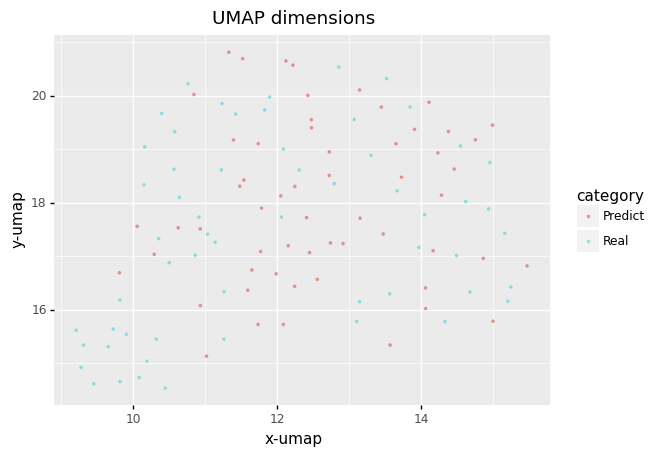

<ggplot: (1407345655541)>

In [45]:
all_latent = np.concatenate([predict_latent, real_latent], axis = 0)
cat_t = ["Real"] * real_latent.shape[0]
cat_g = ["Predict"] * predict_latent.shape[0]
cat_rf_gt = np.append(cat_g, cat_t)
trans = umap.UMAP(random_state=42, min_dist = 0.5, n_neighbors=30).fit(all_latent)
X_embedded_pr = trans.transform(all_latent)
df = X_embedded_pr.copy()
df = pd.DataFrame(df)
df['x-umap'] = X_embedded_pr[:,0]
df['y-umap'] = X_embedded_pr[:,1]
df['category'] = cat_rf_gt
    
chart_pr = ggplot(df, aes(x= 'x-umap', y= 'y-umap', colour = 'category') ) \
    + geom_point(size=0.5, alpha = 0.5) \
    + ggtitle("UMAP dimensions")
chart_pr

**Calculate the rsquare value**

In [46]:
normModel = NormalizedRevisionRSquare(largeCountData = adata_test.layers["counts"].A)

In [47]:
r2_value, _, _ = normModel.calculate_r_square(real_data, predict_data)
r2_value

0.9085225402573653

**Visualize the mapping from the perturbation representation to the cellular representation**
1. We need to generate background embeddings for perturbations and cells, excluding the specific perturbation we want to highlight.
2. Use ```contourplot_space_mapping``` to display the mapping relationships. Ensure you specify enough colors for the highlighted perturbations

In [14]:
background_pert = []
background_cell = []
n_cells_bk = 20
highlights = [unseen_pert]
for i in tqdm(range(len(adata.uns["ordered_all_trt"]))):
    pert = adata.uns["ordered_all_trt"][i]
    if pert in highlights:
        continue
    pert_embed_tmp = adata.uns["ordered_all_onehot"][i]
    Lsample_idx = np.random.choice(range(Lsample_obs.shape[0]), n_cells, replace=True)
    trt_input_fixed_bk = np.tile(pert_embed_tmp, (n_cells_bk, 1))
    _, _, _, embdata_torch_bk =  model_c.model_con(torch.tensor(trt_input_fixed_bk).float().to(device))
    pert_embed_bk = embdata_torch_bk.cpu().detach().numpy()
    library_trt_latent = Lsample_obs[Lsample_idx]
    predict_latent_bk, predict_data_bk = perturbnet_model.sample_data(pert_embed_bk, library_trt_latent)
    
    background_pert.append(pert_embed_bk )
    background_cell.append(predict_latent_bk)
    
background_pert = np.concatenate(background_pert)
background_cell = np.concatenate(background_cell)
    

100%|██████████| 237/237 [00:06<00:00, 36.22it/s]


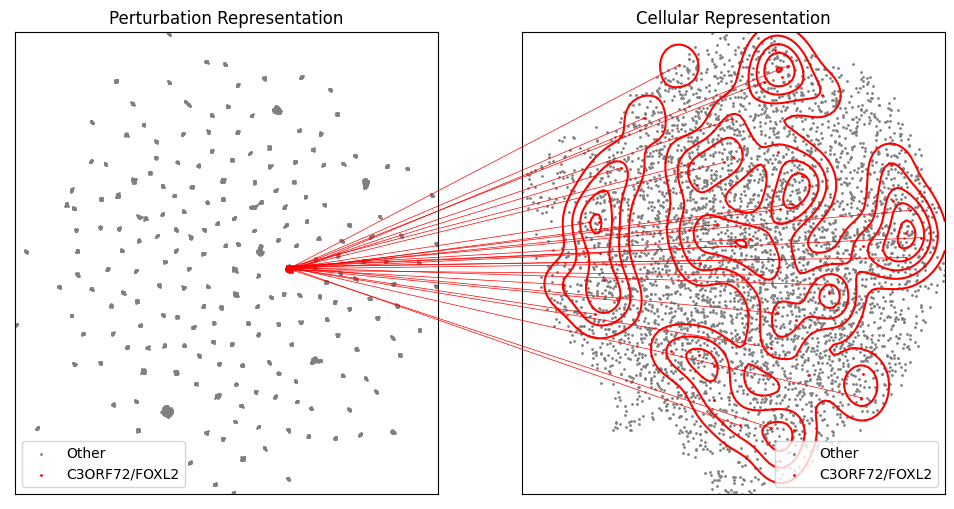

In [15]:
%matplotlib inline
contourplot_space_mapping(predict_latent, pert_embed, background_pert, background_cell, highlight_labels = ["C3ORF72/FOXL2"], colors = ["red"])